# Dogs Breads Classification On AWS

Using AWS Sagemaker and PyTorch to train a RESNET50 pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices.

**steps**:
- downloading data from data source 
- uploading data files S3 Bucket to be used with sagemaker Estimators
- creating PyTorch Custom ResNET18 model that train and predict resnet50 in pytorch to be used as entry point for sagemaker estimator
- creating hyperparameter tuner estimator to initiate 4 training jobs on Sagemaker and find best model parameters
- creating a Sagemaker Training Estimator with the best parameters and adding Debugger and profiler Hooks
- Debugger and Profiler Catches System and training metrics Such as Overfitting.
- Creating a pytorch Estimator with the trained model with inference script as entry point
- the inference script defines what type of data to be accepted through the API and passes to model
- Deploys the Pytorch Estimator to an Endpoint
- cleanup

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [ ]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
Dogs Breads dataset contains 133 different bread of dogs 
the data is divided into train valid test sets we will train the model and try to classify instances in the test set to correct dogs breads

downloading from data source and unzipping

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

### Upload data To S3 Bucket to use it with sagemaker Estimator

In [ ]:
import sagemaker 

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "project_data"
path = "dogImages"
role = sagemaker.get_execution_role()

inputs = session.upload_data(path,bucket,prefix)
print(inputs)

s3://sagemaker-us-east-1-113877381728/project_data


In [5]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

**Loading data from data folder and setting up torch data loader**

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("dogImages/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("dogImages/valid", transform = transforms)
testset = torchvision.datasets.ImageFolder("dogImages/test", transform = transforms)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

**visualizing some training samples data**

[2022-12-09 02:03:56.510 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:33 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-09 02:03:56.715 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:33 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


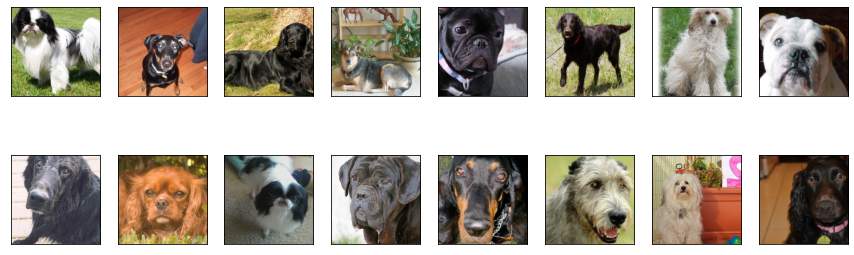

In [8]:
images, labels = iter(trainloader).next()
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')

## Hyperparameter Tuning

using a pretrained resnet18 model we will fine tune the model on our dogs dataset and find the best values of the learning rate and batch size for training

In [84]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (ContinuousParameter,IntegerParameter,CategoricalParameter,HyperparameterTuner)

hyperparameter_ranges = {'batch-size':CategoricalParameter([32,64,128,256]),
                        'lr':ContinuousParameter(0.001,0.1),
                         'epochs':CategoricalParameter([2,4]),}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

**creating Pytorch Sagemaker Estimator to use custom model defiend in hpo.py and hyperparameter tuner to tune it**

In [86]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
                entry_point='hpo.py',
                role=role,
                instance_count=1,
                instance_type='ml.m5.2xlarge',
                framework_version='1.8',
                py_version='py36')

tuner = HyperparameterTuner(estimator,
                           objective_metric_name,
                           hyperparameter_ranges,
                           metric_definitions,
                           max_jobs=4,
                           max_parallel_jobs=2,
                           objective_type=objective_type,
                          )

In [106]:
# TODO: Fit your HP Tuner
tuner.fit({"training":inputs}) # TODO: Remember to include your data channels

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-221208-0527


...........................................................................................................................!


In [107]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-12-08 05:33:19 Starting - Preparing the instances for training
2022-12-08 05:33:19 Downloading - Downloading input data
2022-12-08 05:33:19 Training - Training image download completed. Training in progress.
2022-12-08 05:33:19 Uploading - Uploading generated training model
2022-12-08 05:33:19 Completed - Resource reused by training job: pytorch-training-221208-0527-003-c43e1d5b


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '"4"',
 'lr': '0.0030250628797789227',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-12-08-05-27-58-969"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-113877381728/pytorch-training-2022-12-08-05-27-58-969/source/sourcedir.tar.gz"'}

### best hyperparameters combinations found by sagemaker tuner job:
 {'batch-size': '32', 'epochs': '4', 'lr': '0.0030250628797789227'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Debugger Rules**: catches issues during training such as overfitting and loss not decreasing

**Profiler Rules**: catches Operating System metrics during training such as resources utlization

In [91]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule,ProfilerRule,rule_configs
from sagemaker.debugger import DebuggerHookConfig,ProfilerConfig,FrameworkProfile,CollectionConfig

rules = [Rule.sagemaker(rule_configs.vanishing_gradient()),
        Rule.sagemaker(rule_configs.overfit()),
        Rule.sagemaker(rule_configs.overtraining()),
        Rule.sagemaker(rule_configs.poor_weight_initialization()),
        Rule.sagemaker(rule_configs.loss_not_decreasing()),
        ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport()),]


collection_configs = [
    CollectionConfig(
        name="custom_losses",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
]

debuger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)


#debuger_config = DebuggerHookConfig(hook_parameters={"train.save_interval":"1","eval.save_interval":"1"})
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))

In [92]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch
hyperparameters = {'batch-size': '32','test-batch-size':'32', 'epochs': '4', 'lr': '0.0030250628797789227'}
estimator = PyTorch(
                entry_point='train_model.py',
                role=role,
                instance_count=1,
                instance_type='ml.p2.xlarge',
                hyperparameters= hyperparameters,
                debugger_hook_config= debuger_config,
                profiler_config=profiler_config,
                rules=rules,
                framework_version='1.8',
                py_version='py36')

estimator.fit({"training":"s3://sagemaker-us-east-1-538091196942/project_data"},wait=True)

2022-12-09 05:04:15 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-12-09 05:04:55 Starting - Preparing the instances for training...............
2022-12-09 05:07:47 Downloading - Downloading input data......
2022-12-09 05:08:48 Training - Downloading the training image.....................
2022-12-09 05:12:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-09 05:12:04,807 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-09 05:12:04,831 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-09 05:12:04,834 sagemaker_pytorch_container.training INFO     Invoking use

**Debugger Output**

In [93]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-12-09 05:25:19.896 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-538091196942/pytorch-training-2022-12-09-05-04-15-115/debug-output
[2022-12-09 05:25:20.971 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-09 05:25:21.989 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3

In [94]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [95]:
trial.tensor('CrossEntropyLoss_output_0').values()
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

9

In [96]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


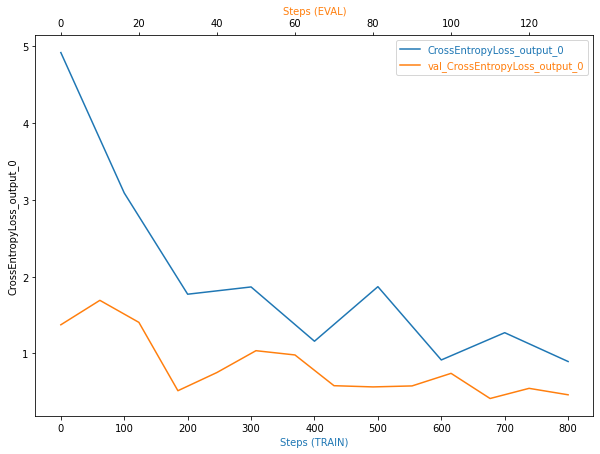

In [97]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [32]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [33]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-12-08 18:32:23     415548 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-08 18:32:22     270177 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-08 18:32:17        192 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-08 18:32:17      48594 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-08 18:32:17       2104 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-08 18:32:17        326 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-12-08 18:32:17      10799 pytorch-training-2022-12-08-18-10-08-551/rule-output/ProfilerReport/profiler-output/profiler-re

In [81]:
import os
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.IFrame(src=profiler_report_name + "/profiler-output/profiler-report.html",width=800,height=600)

## Model Deploying

In [40]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

#model_location=estimator.model_data
import sagemaker
role=sagemaker.get_execution_role()
model_location=estimator.model_data



In [47]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [68]:
pytorch_model = PyTorchModel(
    model_data=model_location,
    role = role,
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=ImagePredictor)


In [69]:
predictor = pytorch_model.deploy(initial_instance_count=1,instance_type="ml.p2.xlarge")

-------------!

Havanese_05576.jpg
dogImages/test/082.Havanese/Havanese_05576.jpg


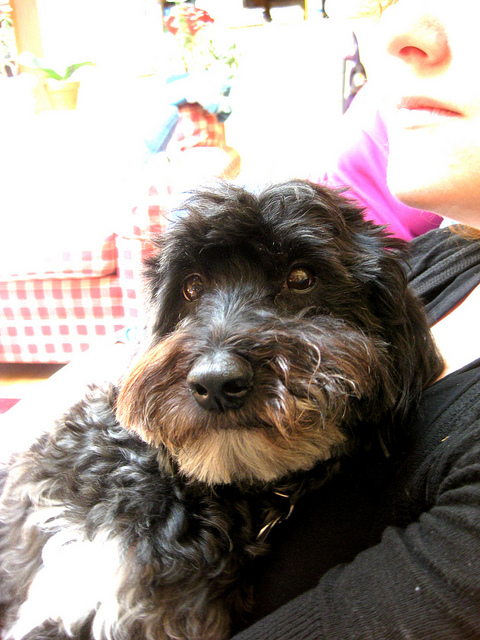

In [70]:
import os, random
from matplotlib import image

random_image_location = random.choice(os.listdir("dogImages/test")) 
random_image_name = random.choice(os.listdir("dogImages/test/"+random_image_location))
print(random_image_name)

data_dir = 'dogImages/test/'+random_image_location+'/'+random_image_name
print(data_dir)

img = Image.open(data_dir)
display(img)
img1 = open(data_dir, 'rb').read()

In [71]:
image_bytes = open(data_dir, 'rb').read()
response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
prediction = np.argmax(response[0]) + 1  

In [74]:
print(f"prediction label = {prediction}")

prediction label = 131


In [67]:
predictor.delete_endpoint()